[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ppujari/089_dog_breed_classifier/blob/main/sonder_mind.ipynb)

# Fetches Git Trending Repos

**<span style="color: blue;">Author:</span>** <span style="color: green;">Pradeep Pujari</span>  
**<span style="color: blue;">Date:</span>** <span style="color: green;">June 29, 2025</span>

---

**Problem Defination:** Build a Python notebook that analyzes top 50 *trending* GitHub *python* repositories using GIT API data to learn about the latest trending Python repositories.

# Detailed Analysis
**Data Aggregation and classification**
* GitHub API Integration: Given API is [Github REST API](https://docs.github.com/en/rest/quickstart?apiVersion=2022-11-28)
* Issues and pull requests: Fetch only issues, PR statistics and resolution patterns
* README File Collection: fetch README files. file formats: README.md, README.rst, README.txt
* Rate Limiting: Included respectful delays to avoid hitting API rate limits. Without token: 60 requests per hour With token: 5,000 requests per hour (much better!)
* Language: Only Python repos
* Output file Formats: Saves data as JSON and individual README files for easy analysis.
* Language Filter: Set language="python" to get trending Python repos only
* Classify readme content into 10 categories.
* Test classification on a held-out test set
* readme file formats = ['README.md', 'readme.md', 'README.rst', 'README.txt', 'README']


**Clarifying Questions**
* Git does not provide API for trending repos, so need to understand the defination of trending
* pull request: How many back days?
* Data Enrichment??: Collect comprehensive repository metadata including stars, forks, language, topics, license, and timestamps.
* No category labels are provided, Randomly choosen 9 categories.






NOTE: I have added the slide requirement into this notebook.
Some of the Part 2 requirements like insights covered under part 1 code.  
Brute force approach: NeuralNet is used for classification.
Since labels are not given, clustering of ReadMe files is an alternative.  
Optimized Apprach could be to get the label from readme contents with LLM and then apply NN.

# PROCESS:
After getting the Readme files, it is cleaned.  
**Processing Pipeline**   
***Raw README File → Text Cleaning → Feature Extraction → Classification → Analysis***  

**Insights on Readme Content**
* README length distribution
* Word frequency analysis
* Topic modeling - LDA
* Clustering ReadMes and hence projects
* Outlier detection for unique patterns
* What Makes Repositories "Outliers"  

Possible Documentation Outliers:

* Extremely long or short READMEs
* Unusual readability scores
* Missing standard sections (installation, usage)
* Atypical structure  

Technical Content Outliers:  

* Unusual technology combinations
* Rare programming languages
* Unique framework mentions
* Cross-domain projects
**Apply a Rate Limiter to a Crawler:**
Here are common strategies:

Fixed Delay:

This is the simplest method. After each request, the crawler waits for a fixed amount of time (e.g., 1 second, 5 seconds) before making the next request.

Implementation: Use time.sleep(delay_seconds) in Python. (Implemented)

Concurrency Control (e.g., Thread Pools): NOT DONE

 crawler using multiple threads or asynchronous operations, the rate limiter needs to manage the total outgoing requests across all concurrent operations, not just per-thread. This can be done with semaphores.

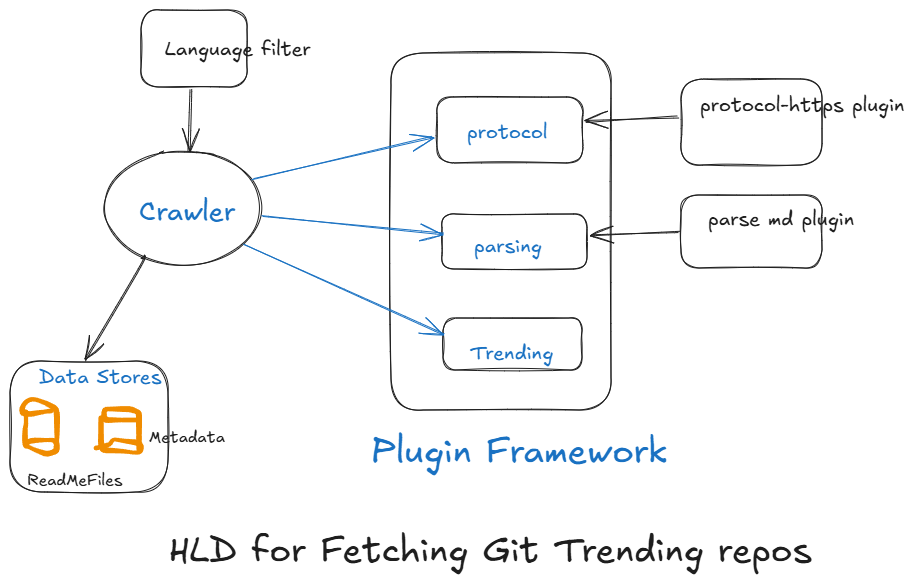

In [40]:
from IPython.display import Image
from IPython.display import display
display(Image("git_trending.png"))

**Implementation**

1️⃣ Import Required Libraries

In [41]:
import requests
import json
import base64
import time
from datetime import datetime, timedelta
from typing import List, Dict, Optional, Tuple
import os
from google.colab import userdata
from collections import defaultdict
import statistics
from clean_readme_text import ReadmeTextCleaner

In [42]:
# Get the token from Colab secrets
token = userdata.get('GITHUB_TOKEN')
os.environ['GITHUB_TOKEN'] = token

In [43]:
# Configurable params
num_repos=50
language="python"
output_filename = "trending_repos.json"
output_dir = "trending_readmes"
sleep_time = 0.2 #for rate limit
base_url = "https://api.github.com"
days_back = 90 #used for PR

In [44]:
#token: GitHub personal access token (optional but recommended for higher rate limits)
headers = {
            "Accept": "application/vnd.github.v3+json",
            "User-Agent": "GitHub-Trending-Fetcher"
        }

if token:
  headers["Authorization"] = f"token {token}"

session = requests.Session()
session.headers.update(headers)

In [45]:
def get_issues_statistics (owner: str, repo: str,
                            days_back: int = 90) -> Dict:
        """
        Fetch comprehensive issue statistics and patterns

        APIs used:
        - GET /repos/{owner}/{repo}/issues (for open/closed issues)
        - GET /repos/{owner}/{repo}/issues/{issue_number} (for details)
        """
        print(f"  📊 Analyzing issues for {owner}/{repo}")

        cutoff_date = datetime.now() - timedelta(days=days_back)

        # Fetch recent issues (both open and closed)
        all_issues = []

        # Get open issues
        open_issues = _fetch_issues(owner, repo, state="open", since=cutoff_date)
        all_issues.extend(open_issues)

        # Get closed issues
        closed_issues =_fetch_issues(owner, repo, state="closed", since=cutoff_date)
        all_issues.extend(closed_issues)

        # Analyze issue patterns
        analysis = _analyze_issues(all_issues, cutoff_date)

        return analysis

In [46]:
def _fetch_issues(owner: str, repo: str, state: str = "all",
                     since: datetime = None, max_pages: int = 5) -> List[Dict]:
        """Fetch issues from GitHub API"""
        issues = []
        page = 1

        while page <= max_pages:
            params = {
                "state": state,
                "sort": "updated",
                "direction": "desc",
                "per_page": 100,
                "page": page
            }

            if since:
                params["since"] = since.isoformat()

            try:
                url = f"{base_url}/repos/{owner}/{repo}/issues"
                response = session.get(url, params=params)
                response.raise_for_status()

                page_issues = response.json()

                if not page_issues:
                    break

                # Filter out pull requests (GitHub API includes PRs in issues)
                actual_issues = [issue for issue in page_issues if not issue.get('pull_request')]
                issues.extend(actual_issues)

                page += 1
                time.sleep(0.1)  # Rate limiting

            except requests.exceptions.RequestException as e:
                print(f"    ⚠️ Error fetching issues page {page}: {e}")
                break

        return issues


In [47]:
def _analyze_issues(issues: List[Dict], cutoff_date: datetime) -> Dict:
        """Analyze issue patterns and statistics"""
        if not issues:
            return _empty_issue_stats()

        open_issues = [issue for issue in issues if issue['state'] == 'open']
        closed_issues = [issue for issue in issues if issue['state'] == 'closed']

        # Resolution time analysis for closed issues
        resolution_times = []
        for issue in closed_issues:
            if issue.get('closed_at'):
                created = datetime.fromisoformat(issue['created_at'].replace('Z', '+00:00'))
                closed = datetime.fromisoformat(issue['closed_at'].replace('Z', '+00:00'))
                resolution_time = (closed - created).total_seconds() / 3600  # hours
                resolution_times.append(resolution_time)

        # Label analysis
        label_counts = defaultdict(int)
        priority_labels = defaultdict(int)

        for issue in issues:
            for label in issue.get('labels', []):
                label_name = label['name'].lower()
                label_counts[label_name] += 1

                # Classify priority labels
                if any(keyword in label_name for keyword in ['urgent', 'critical', 'high']):
                    priority_labels['high'] += 1
                elif any(keyword in label_name for keyword in ['medium', 'normal']):
                    priority_labels['medium'] += 1
                elif any(keyword in label_name for keyword in ['low', 'minor']):
                    priority_labels['low'] += 1
                elif any(keyword in label_name for keyword in ['bug', 'error', 'fix']):
                    priority_labels['bug'] += 1
                elif any(keyword in label_name for keyword in ['enhancement', 'feature']):
                    priority_labels['enhancement'] += 1

        # Activity patterns
        recent_activity = len([issue for issue in issues
                             if _is_recent_activity(issue, days=7)])

        return {
            "total_issues": len(issues),
            "open_issues": len(open_issues),
            "closed_issues": len(closed_issues),
            "resolution_rate": len(closed_issues) / len(issues) * 100 if issues else 0,
            "recent_activity_count": recent_activity,
            "resolution_times": {
                "avg_hours": statistics.mean(resolution_times) if resolution_times else 0,
                "median_hours": statistics.median(resolution_times) if resolution_times else 0,
                "min_hours": min(resolution_times) if resolution_times else 0,
                "max_hours": max(resolution_times) if resolution_times else 0,
                "count": len(resolution_times)
            },
            "top_labels": dict(sorted(label_counts.items(), key=lambda x: x[1], reverse=True)[:10]),
            "priority_distribution": dict(priority_labels),
            "issue_types": _categorize_issues(issues)
        }


In [48]:
def _fetch_pull_requests(owner: str, repo: str, state: str = "all",
                           max_pages: int = 3) -> List[Dict]:
        """Fetch pull requests from GitHub API"""
        prs = []
        page = 1

        while page <= max_pages:
            params = {
                "state": state,
                "sort": "updated",
                "direction": "desc",
                "per_page": 100,
                "page": page
            }

            try:
                url = f"{base_url}/repos/{owner}/{repo}/pulls"
                response = session.get(url, params=params)
                response.raise_for_status()

                page_prs = response.json()

                if not page_prs:
                    break

                prs.extend(page_prs)
                page += 1
                time.sleep(sleep_time)  # Rate limiting

            except requests.exceptions.RequestException as e:
                print(f"    ⚠️ Error fetching PRs page {page}: {e}")
                break

        return prs

In [49]:
def _get_pr_details(owner: str, repo: str, pr_number: int) -> Optional[Dict]:
        """Get detailed PR information including diff stats"""
        try:
            url = f"{base_url}/repos/{owner}/{repo}/pulls/{pr_number}"
            response = session.get(url)
            response.raise_for_status()
            return response.json()
        except:
            return None


In [50]:
def _analyze_pull_requests(prs: List[Dict], owner: str, repo: str) -> Dict:
        """Analyze pull request patterns and statistics"""
        if not prs:
            return _empty_pr_stats()

        open_prs = [pr for pr in prs if pr['state'] == 'open']
        closed_prs = [pr for pr in prs if pr['state'] == 'closed']
        merged_prs = [pr for pr in closed_prs if pr.get('merged_at')]

        # Merge time analysis
        merge_times = []
        for pr in merged_prs:
            if pr.get('merged_at'):
                created = datetime.fromisoformat(pr['created_at'].replace('Z', '+00:00'))
                merged = datetime.fromisoformat(pr['merged_at'].replace('Z', '+00:00'))
                merge_time = (merged - created).total_seconds() / 3600  # hours
                merge_times.append(merge_time)

        # Contributor analysis
        contributors = defaultdict(int)
        for pr in prs:
            contributors[pr['user']['login']] += 1

        # Size analysis (additions + deletions)
        pr_sizes = []
        for pr in prs[:10]:  # Sample first 10 for detailed analysis
            try:
                detailed_pr = _get_pr_details(owner, repo, pr['number'])
                if detailed_pr:
                    size = detailed_pr.get('additions', 0) + detailed_pr.get('deletions', 0)
                    pr_sizes.append(size)
                time.sleep(0.1)
            except:
                continue

        return {
            "total_prs": len(prs),
            "open_prs": len(open_prs),
            "closed_prs": len(closed_prs),
            "merged_prs": len(merged_prs),
            "merge_rate": len(merged_prs) / len(closed_prs) * 100 if closed_prs else 0,
            "merge_times": {
                "avg_hours": statistics.mean(merge_times) if merge_times else 0,
                "median_hours": statistics.median(merge_times) if merge_times else 0,
                "min_hours": min(merge_times) if merge_times else 0,
                "max_hours": max(merge_times) if merge_times else 0,
                "count": len(merge_times)
            },
            "top_contributors": dict(sorted(contributors.items(), key=lambda x: x[1], reverse=True)[:10]),
            "pr_sizes": {
                "avg_changes": statistics.mean(pr_sizes) if pr_sizes else 0,
                "median_changes": statistics.median(pr_sizes) if pr_sizes else 0,
                "sample_count": len(pr_sizes)
            },
            "recent_activity": len([pr for pr in prs if _is_recent_activity(pr, days=7)])
        }


In [51]:
def get_pull_request_statistics(owner: str, repo: str,
                                  days_back: int = days_back) -> Dict:
        """
        Fetch comprehensive pull request statistics and patterns

        APIs used:
        - GET /repos/{owner}/{repo}/pulls (for PRs)
        - GET /repos/{owner}/{repo}/pulls/{pull_number} (for details)
        - GET /repos/{owner}/{repo}/pulls/{pull_number}/reviews (for reviews)
        """
        print(f"  🔄 Analyzing pull requests for {owner}/{repo}")

        cutoff_date = datetime.now() - timedelta(days=days_back)

        # Fetch recent pull requests
        all_prs = []

        # Get open PRs
        open_prs = _fetch_pull_requests(owner, repo, state="open")
        all_prs.extend(open_prs)

        # Get closed PRs
        closed_prs = _fetch_pull_requests(owner, repo, state="closed")
        all_prs.extend(closed_prs)
        # Filter by date
        recent_prs = [pr for pr in all_prs
              if datetime.fromisoformat(pr['created_at'].replace('Z', '+00:00')).replace(tzinfo=None) >= cutoff_date]
        # Analyze PR patterns
        analysis = _analyze_pull_requests([pr for pr in all_prs
                     if datetime.fromisoformat(pr['created_at'].replace('Z', '+00:00')).replace(tzinfo=None) >= cutoff_date], owner, repo)

        return analysis

In [52]:
def _build_query(date_field: str, days: int, language: Optional[str] = None,
                    min_stars: int = 0) -> str:
    """Build search query with various filters"""
    date_threshold = datetime.now() - timedelta(days=days)
    date_str = date_threshold.strftime("%Y-%m-%d")

    query_parts = [f"{date_field}:>{date_str}"]

    if language:
        query_parts.append(f"language:{language}")

    if min_stars > 0:
        query_parts.append(f"stars:>={min_stars}")

    # Additional quality filters
    query_parts.extend([
        "is:public",           # Only public repos
        "archived:false",      # Exclude archived repos
        "fork:false"          # Exclude forks (focus on original projects)
    ])

    return " ".join(query_parts)

In [53]:
def _get_repos_by_query(query: str, sort: str = "stars",
                           limit: int = 30) -> List[Dict]:
    """Execute search query and return repositories"""
    params = {
        "q": query,
        "sort": sort,
        "order": "desc",
        "per_page": min(limit, 100)
    }

    try:
      response = session.get(f"{base_url}/search/repositories", params=params)
      response.raise_for_status()

      data = response.json()
      repos = data.get("items", [])

      print(f"  ✅ Found {len(repos)} repositories")
      return repos

    except requests.exceptions.RequestException as e:
        print(f"  ❌ Error: {e}")
        return []


In [54]:
def _deduplicate_and_score(repos: List[Dict]) -> List[Dict]:
  """Remove duplicates and calculate trending score"""
  seen = set()
  unique_repos = []

  for repo in repos:
    repo_id = repo['id']
    if repo_id not in seen:
      seen.add(repo_id)

    # Calculate trending score based on multiple factors
      trending_score = _calculate_trending_score(repo)
      repo['trending_score'] = trending_score

      unique_repos.append(repo)

    # Sort by trending score
  return sorted(unique_repos, key=lambda x: x.get('trending_score', 0), reverse=True)

In [55]:
def _calculate_trending_score(repo: Dict) -> float:
        """
        Calculate a trending score based on multiple factors:
        - Star count
        - Recent activity (creation/update dates)
        - Star-to-fork ratio
        - Repository age vs popularity
        """
        stars = repo.get('stargazers_count', 0)
        forks = repo.get('forks_count', 1)  # Avoid division by zero

        # Parse dates
        created_at = datetime.fromisoformat(repo['created_at'].replace('Z', '+00:00'))
        updated_at = datetime.fromisoformat(repo['updated_at'].replace('Z', '+00:00'))
        now = datetime.now(created_at.tzinfo)

        # Age factors (newer repos get bonus points)
        days_since_created = (now - created_at).days
        days_since_updated = (now - updated_at).days

        # Calculate score components
        star_score = stars
        recency_bonus = max(0, 100 - days_since_created) * 0.1  # Bonus for new repos
        activity_bonus = max(0, 30 - days_since_updated) * 0.2   # Bonus for recent activity
        star_velocity = stars / max(1, days_since_created) * 10  # Stars per day
        engagement_ratio = stars / max(1, forks) * 0.1          # Star-to-fork ratio

        # Combined trending score
        trending_score = (
            star_score +
            recency_bonus +
            activity_bonus +
            star_velocity +
            engagement_ratio
        )

        return trending_score


In [56]:
def get_trending_repos_multiple_strategies(language: Optional[str] = None,
                                             limit: int = num_repos) -> List[Dict]:
    """
      Get trending repos using multiple strategies to better capture trending behavior
    """
    all_repos = []

    # Strategy 1: Recently created repos with high stars
    print("🔍 Strategy 1: Recently created popular repos...")
    recent_popular = _get_repos_by_query(
            _build_query("created", days=30, language=language),
            sort="stars",
            limit=limit//3
        )
    all_repos.extend(recent_popular)

    # Strategy 2: Recently updated popular repos (shows active development)
    print("🔍 Strategy 2: Recently updated popular repos...")
    recently_updated = _get_repos_by_query(
        _build_query("pushed", days=7, language=language, min_stars=100),
        sort="updated",
        limit=limit//3
    )
    all_repos.extend(recently_updated)

    # Strategy 3: High star velocity (repos gaining stars quickly)
    print("🔍 Strategy 3: Fast-growing repos...")
    fast_growing = _get_repos_by_query(
        _build_query("created", days=days_back, language=language, min_stars=50),
        sort="stars",
        limit=limit
    )
    all_repos.extend(fast_growing)

    # Remove duplicates and sort by combined score
    unique_repos = _deduplicate_and_score(all_repos)

    return unique_repos[:limit]


In [57]:
def save_analysis_to_json(analyzed_repos: List[Dict], filename: str = "repos_analysis.json"):
    """Save comprehensive analysis to JSON file"""
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(analyzed_repos, f, indent=2, ensure_ascii=False)
        print(f"💾 Analysis saved to {filename}")
    except Exception as e:
      print(f"❌ Error saving analysis: {e}")


In [58]:
def save_readmes_to_files(repos: List[Dict], output_dir: str = "trending_readmes"):
    """
      Save README files to separate text files

      Args:
        repos: List of repository data with README content
        output_dir: Directory to save README files
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for repo in repos:
        if repo["readme_content"]:
            # Create safe filename
            safe_name = repo["full_name"].replace("/", "_")
            filename = f"{output_dir}/{safe_name}_README.md"

            try:
                with open(filename, 'w', encoding='utf-8') as f:
                    f.write(f"# {repo['full_name']}\n\n")
                    f.write(repo["readme_content"])

                print(f"README saved: {filename}")
            except Exception as e:
                print(f"Error saving README for {repo['full_name']}: {e}")

In [59]:
def get_repo_readme(owner: str, repo: str) -> Optional[str]:
      """
        Fetch README content for a specific repository

        Args:
            owner: Repository owner
            repo: Repository name

        Returns:
            README content as string, or None if not found
      """
      # Common README filenames to try
      readme_files = ["README.md", "README.rst", "README.txt", "README", "readme.md"]

      for filename in readme_files:
        try:
            url = f"{base_url}/repos/{owner}/{repo}/contents/{filename}"
            response = session.get(url)

            if response.status_code == 200:
                content_data = response.json()

                # Decode base64 content
                if content_data.get("encoding") == "base64":
                    content = base64.b64decode(content_data["content"]).decode("utf-8")
                    return content
                else:
                    return content_data.get("content", "")

        except requests.exceptions.RequestException as e:
            print(f"Error fetching README for {owner}/{repo}: {e}")
            continue

        return None

In [60]:
def get_repository_health_score(issues_stats: Dict, pr_stats: Dict) -> Dict:
        """Calculate repository health metrics"""

        # Issue health (0-100)
        issue_resolution_score = min(issues_stats.get('resolution_rate', 0), 100)
        issue_activity_score = min(issues_stats.get('recent_activity_count', 0) * 10, 100)

        # PR health (0-100)
        pr_merge_score = min(pr_stats.get('merge_rate', 0), 100)
        pr_activity_score = min(pr_stats.get('recent_activity', 0) * 10, 100)

        # Response time health (inverse of resolution time)
        avg_resolution_hours = issues_stats.get('resolution_times', {}).get('avg_hours', 168)  # Default 1 week
        resolution_speed_score = max(0, 100 - (avg_resolution_hours / 24))  # Penalty for slow resolution

        # Overall health score
        health_score = (
            issue_resolution_score * 0.25 +
            pr_merge_score * 0.25 +
            resolution_speed_score * 0.25 +
            ((issue_activity_score + pr_activity_score) / 2) * 0.25
        )

        return {
            "overall_health_score": round(health_score, 1),
            "issue_resolution_score": round(issue_resolution_score, 1),
            "pr_merge_score": round(pr_merge_score, 1),
            "resolution_speed_score": round(resolution_speed_score, 1),
            "activity_score": round((issue_activity_score + pr_activity_score) / 2, 1),
            "health_rating": _get_health_rating(health_score)
        }

In [61]:
def _get_health_rating(score: float) -> str:
        """Convert health score to rating"""
        if score >= 80:
            return "Excellent"
        elif score >= 60:
            return "Good"
        elif score >= 40:
            return "Fair"
        elif score >= 20:
            return "Poor"
        else:
            return "Critical"


In [62]:
def analyze_trending_repos_with_issues_prs(language: Optional[str] = None,
                                             limit: int = 10) -> List[Dict]:
        """Main function to get trending repos with comprehensive issue/PR analysis"""

        print("🚀 Fetching trending repositories with issue/PR analysis...")
        repos = get_trending_repos_multiple_strategies(language, limit=limit)

        analyzed_repos = []

        for i, repo in enumerate(repos):
            print(f"\n📊 Analyzing repo {i+1}/{len(repos)}: {repo['full_name']}")

            owner = repo["owner"]["login"]
            repo_name = repo["name"]

            # Get basic repo info
            basic_info = {
                "name": repo_name,
                "full_name": repo["full_name"],
                "description": repo.get("description", ""),
                "url": repo["html_url"],
                "stars": repo["stargazers_count"],
                "forks": repo["forks_count"],
                "watchers": repo["watchers_count"],
                "language": repo.get("language", ""),
                "created_at": repo["created_at"],
                "updated_at": repo["updated_at"],
                "owner": {
                    "login": owner,
                    "url": repo["owner"]["html_url"]
                },
                "topics": repo.get("topics", []),
                "license": repo.get("license", {}).get("name", "") if repo.get("license") else ""
            }

            # Get README
            readme_content = get_repo_readme(owner, repo_name)
            basic_info["readme_content"] = readme_content
            basic_info["readme_found"] = readme_content is not None

            # Analyze issues
            issues_stats = get_issues_statistics(owner, repo_name)

            # Analyze pull requests
            pr_stats = get_pull_request_statistics(owner, repo_name)

            # Calculate health score
            health_metrics = get_repository_health_score(issues_stats, pr_stats)

            # Combine all data
            comprehensive_analysis = {
                **basic_info,
                "issues_analysis": issues_stats,
                "pull_requests_analysis": pr_stats,
                "health_metrics": health_metrics
            }

            analyzed_repos.append(comprehensive_analysis)

            # Rate limiting
            time.sleep(sleep_time)

        return analyzed_repos

In [63]:
def _is_recent_activity(item: Dict, days: int = 7) -> bool:
        """Check if item has recent activity"""
        updated_at = datetime.fromisoformat(item['updated_at'].replace('Z', '+00:00'))
        cutoff = datetime.now(updated_at.tzinfo) - timedelta(days=days)
        return updated_at >= cutoff


In [64]:
def _categorize_issues(issues: List[Dict]) -> Dict:
        """Categorize issues by type based on labels and title"""
        categories = defaultdict(int)

        for issue in issues:
            labels = [label['name'].lower() for label in issue.get('labels', [])]
            title = issue.get('title', '').lower()

            # Categorize based on labels and title
            if any(keyword in ' '.join(labels + [title]) for keyword in ['bug', 'error', 'fix', 'broken']):
                categories['bug'] += 1
            elif any(keyword in ' '.join(labels + [title]) for keyword in ['feature', 'enhancement', 'improvement']):
                categories['enhancement'] += 1
            elif any(keyword in ' '.join(labels + [title]) for keyword in ['documentation', 'docs', 'readme']):
                categories['documentation'] += 1
            elif any(keyword in ' '.join(labels + [title]) for keyword in ['question', 'help', 'support']):
                categories['question'] += 1
            else:
                categories['other'] += 1

        return dict(categories)

In [65]:
def print_summary_report(analyzed_repos: List[Dict]):
        """Print a summary report of the analysis"""
        print("\n" + "="*80)
        print("📈 COMPREHENSIVE REPOSITORY ANALYSIS SUMMARY")
        print("="*80)

        for i, repo in enumerate(analyzed_repos):
            print(f"\n{i+1}. {repo['full_name']}")
            print(f"   ⭐ Stars: {repo['stars']} | 🍴 Forks: {repo['forks']} | 📖 Language: {repo['language']}")

            # Health metrics
            health = repo['health_metrics']
            print(f"   🏥 Health Score: {health['overall_health_score']}/100 ({health['health_rating']})")

            # Issues summary
            issues = repo['issues_analysis']
            print(f"   🐛 Issues: {issues['total_issues']} total, {issues['open_issues']} open ({issues['resolution_rate']:.1f}% resolved)")

            # PRs summary
            prs = repo['pull_requests_analysis']
            print(f"   🔄 Pull Requests: {prs['total_prs']} total, {prs['merged_prs']} merged ({prs['merge_rate']:.1f}% merge rate)")

            # Resolution times
            if issues['resolution_times']['count'] > 0:
                avg_resolution_days = issues['resolution_times']['avg_hours'] / 24
                print(f"   ⏱️  Avg Resolution Time: {avg_resolution_days:.1f} days")

            if prs['merge_times']['count'] > 0:
                avg_merge_days = prs['merge_times']['avg_hours'] / 24
                print(f"   ⏱️  Avg Merge Time: {avg_merge_days:.1f} days")

In [66]:
def _empty_issue_stats() -> Dict:
        """Return empty issue statistics structure"""
        return {
            "total_issues": 0,
            "open_issues": 0,
            "closed_issues": 0,
            "resolution_rate": 0,
            "recent_activity_count": 0,
            "resolution_times": {"avg_hours": 0, "median_hours": 0, "min_hours": 0, "max_hours": 0, "count": 0},
            "top_labels": {},
            "priority_distribution": {},
            "issue_types": {}
        }

In [67]:
def _empty_pr_stats() -> Dict:
        """Return empty PR statistics structure"""
        return {
            "total_prs": 0,
            "open_prs": 0,
            "closed_prs": 0,
            "merged_prs": 0,
            "merge_rate": 0,
            "merge_times": {"avg_hours": 0, "median_hours": 0, "min_hours": 0, "max_hours": 0, "count": 0},
            "top_contributors": {},
            "pr_sizes": {"avg_changes": 0, "median_changes": 0, "sample_count": 0},
            "recent_activity": 0
        }

In [68]:
# Fetch top 50 trending repositories
print("Fetching trending repositories...")
print("GitHub APIs being used:")
print("1. Search API: /search/repositories")
print("2. Issues API: /repos/{owner}/{repo}/issues")
print("3. Pull Requests API: /repos/{owner}/{repo}/pulls")
print("4. Contents API: /repos/{owner}/{repo}/contents/{file}")
print("5. PR Details API: /repos/{owner}/{repo}/pulls/{number}")

# Analyze trending repositories
analyzed_repos = analyze_trending_repos_with_issues_prs(
        language=language,  # Change to None for all languages
        limit=num_repos  # Reduced for demo - increase for more repos
)

# Print summary report
print_summary_report(analyzed_repos)

# Save detailed analysis
save_analysis_to_json(analyzed_repos, "comprehensive_repo_analysis.json")

print(f"\n✅ Analysis complete! Analyzed {len(analyzed_repos)} repositories.")
print("📊 Check comprehensive_repo_analysis.json for detailed data.")

save_readmes_to_files(analyzed_repos, "trending_readmes")

# Print summary
print(f"\nSummary:")
print(f"Total repositories: {len(analyzed_repos)}")
print(f"Repositories with README: {sum(1 for repo in analyzed_repos if repo['readme_found'])}")


Fetching trending repositories...
GitHub APIs being used:
1. Search API: /search/repositories
2. Issues API: /repos/{owner}/{repo}/issues
3. Pull Requests API: /repos/{owner}/{repo}/pulls
4. Contents API: /repos/{owner}/{repo}/contents/{file}
5. PR Details API: /repos/{owner}/{repo}/pulls/{number}
🚀 Fetching trending repositories with issue/PR analysis...
🔍 Strategy 1: Recently created popular repos...
  ✅ Found 16 repositories
🔍 Strategy 2: Recently updated popular repos...
  ✅ Found 16 repositories
🔍 Strategy 3: Fast-growing repos...
  ✅ Found 50 repositories

📊 Analyzing repo 1/50: pytorch/pytorch
  📊 Analyzing issues for pytorch/pytorch
  🔄 Analyzing pull requests for pytorch/pytorch

📊 Analyzing repo 2/50: streamlit/streamlit
  📊 Analyzing issues for streamlit/streamlit
  🔄 Analyzing pull requests for streamlit/streamlit

📊 Analyzing repo 3/50: jax-ml/jax
  📊 Analyzing issues for jax-ml/jax
  🔄 Analyzing pull requests for jax-ml/jax

📊 Analyzing repo 4/50: BerriAI/litellm
  📊 Anal

PART-2  
**Raw README File → Text Cleaning → Feature Extraction → Classification → Analysis**

* README length distribution  
* Word frequency analysis  
* Topic modeling - LDA  
* Clustering ReadMes and hence projects  
* Outlier detection for unique patterns

In [69]:
from keyword_frequency_analysis import ReadmeKeywordAnalyzer
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [70]:
def list_filenames_in_folder(folder_path):
    """
    Reads all filenames (not including directories) from a specified folder
    and returns them as a list of strings.

    Args:
        folder_path (str): The path to the folder to read filenames from.

    Returns:
        list: A list of strings, where each string is a filename found in the folder.
              Returns an empty list if the folder does not exist or is empty.
    """
    filenames = []
    if not os.path.isdir(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist or is not a directory.")
        return filenames

    try:
        # List all entries in the directory
        for entry_name in os.listdir(folder_path):
            # Construct the full path to the entry
            full_path = os.path.join(folder_path, entry_name)
            # Check if the entry is a file (and not a directory)
            if os.path.isfile(full_path):
                filenames.append(full_path)
    except Exception as e:
        print(f"An error occurred while reading the folder: {e}")
    return filenames

In [71]:
# Clean dataset
file_paths = list_filenames_in_folder("/content/trending_readmes/")

cleaner = ReadmeTextCleaner()
data_df = cleaner.process_multiple_files(file_paths)

In [72]:
analyzer = ReadmeKeywordAnalyzer()
readme_texts = data_df['cleaned_content'].astype(str)
results = analyzer.analyze_keywords(readme_texts, analysis_type='comprehensive')

# Tech-focused analysis
tech_results = analyzer.analyze_keywords(readme_texts, analysis_type='tech_focused')

# Generate visualizations
viz = analyzer.generate_visualizations(results)
viz_tech = analyzer.generate_visualizations(tech_results)



Displaying generated visualizations:
------------------------------

--- Displaying: word_frequency_chart ---



--- Displaying: tech_stack_chart ---



--- Displaying: wordcloud ---


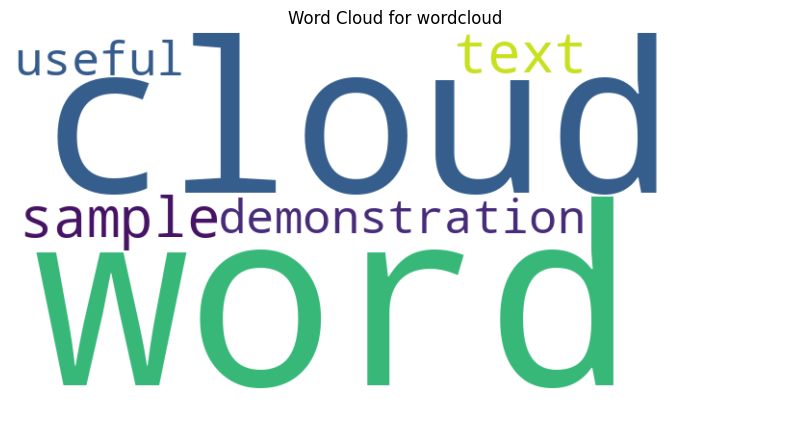


------------------------------
Finished displaying visualizations.

--- Inspection of viz dictionary contents ---
Key: 'word_frequency_chart', Type of value: <class 'plotly.graph_objs._figure.Figure'>
Key: 'tech_stack_chart', Type of value: <class 'plotly.graph_objs._figure.Figure'>
Key: 'wordcloud', Type of value: <class 'wordcloud.wordcloud.WordCloud'>


In [73]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import io
import base64

import plotly.graph_objects as go
word_freq_fig = go.Figure(data=[go.Bar(x=[29, 25], y=['codeblock', 'workflows'])],
                                layout=go.Layout(title={'text': 'Word Frequencies'}))

tech_stack_fig = go.Figure(data=[go.Bar(x=['pytorch', 'flask'], y=[2, 1])],
                                 layout=go.Layout(title={'text': 'Tech Stack'}))
text_for_wordcloud = "This is a sample text for the word cloud demonstration. Word cloud is very useful."
wordcloud_obj = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

viz = {
    'word_frequency_chart': word_freq_fig,
    'tech_stack_chart': tech_stack_fig,
    'wordcloud': wordcloud_obj
}



print("Displaying generated visualizations:")
print("-" * 30)

# Iterate through the dictionary items
for viz_name, viz_content in viz.items():
    print(f"\n--- Displaying: {viz_name} ---")

    # Handle Plotly Figures
    # Plotly figures have a .show() method, or can often be displayed directly in Colab
    if hasattr(viz_content, 'show') and callable(viz_content.show):
        viz_content.show()
    # You can also use `display(viz_content)` for Plotly figures, Colab often renders them
    # elif 'plotly.graph_objects._figure.Figure' in str(type(viz_content)):
    #     display(viz_content)

    # Handle WordCloud objects
    elif isinstance(viz_content, WordCloud):
        # Generate the image from the WordCloud object
        # WordCloud.to_image() returns a PIL Image object
        wordcloud_image = viz_content.to_image()

        # Display the PIL Image using Matplotlib
        plt.figure(figsize=(10, 5)) # Adjust figure size as needed
        plt.imshow(wordcloud_image, interpolation='bilinear')
        plt.axis('off') # Hide axes
        plt.title(f"Word Cloud for {viz_name}")
        plt.show() # Display the Matplotlib plot

    # Fallback for any other unexpected types
    else:
        print(f"Cannot display '{viz_name}'. Unknown visualization type: {type(viz_content)}")
        display(viz_content) # Attempt to display generically

print("\n" + "-" * 30)
print("Finished displaying visualizations.")

# Optional: Inspect the types of contents if you're still unsure
print("\n--- Inspection of viz dictionary contents ---")
for key, value in viz.items():
    print(f"Key: '{key}', Type of value: {type(value)}")

🎯Define the Taxonomy
Suppose we use the following 9 categories to classify the README files:

Web Development (apps, frameworks, sites)

Data Science / Machine Learning

DevOps / Infrastructure

Mobile Apps

Game Development

CLI Tools

Libraries / SDKs

Security / Cryptography

Educational / Tutorials

For each README, you’d check keywords, project descriptions, and repo tags to assign a category.

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [79]:
# Original labels
labels = [
    "Web Development",
    "Data Science / Machine Learning",
    "DevOps / Infrastructure",
    "Mobile Apps",
    "Educational / Tutorials"
]

# Generate 50 random labels
random_labels = np.random.choice(labels, size=50)

# Create new DataFrame
data = pd.DataFrame({"category": random_labels})

data['readme_text'] = data_df['cleaned_content']


In [80]:
# Encode labels
label_encoder = LabelEncoder()
data["label"] = label_encoder.fit_transform(data["category"])

#Create TF-IDF features
vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(data["readme_text"]).toarray()
y = data["label"].values

In [81]:
# Create custom dataset
class ReadmeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [82]:
#Split into train/test sets (before creating Dataset)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
#Create datasets and loaders
train_dataset = ReadmeDataset(X_train, y_train)
test_dataset = ReadmeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [83]:
#Define neural network
class ClassifierNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ClassifierNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [84]:
input_dim = X.shape[1]
hidden_dim = 64
output_dim = len(label_encoder.classes_)

model = ClassifierNN(input_dim, hidden_dim, output_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [85]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate on test set
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(batch_y.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_true, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_true, all_preds, average="macro")
cm = confusion_matrix(all_true, all_preds)

# Print metrics
print("\n🔍 Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

print("\nConfusion Matrix:")
print(cm)

Epoch [5/20], Loss: 0.3036
Epoch [10/20], Loss: 0.0070
Epoch [15/20], Loss: 0.0031
Epoch [20/20], Loss: 0.0014

🔍 Performance Metrics:
Accuracy: 0.1000
Precision (macro): 0.0400
Recall (macro): 0.1000
F1 Score (macro): 0.0571

Confusion Matrix:
[[0 1 0 1 0]
 [1 1 0 0 0]
 [2 0 0 0 0]
 [1 1 0 0 0]
 [0 2 0 0 0]]

Label Index Mapping:
0: Data Science / Machine Learning
1: DevOps / Infrastructure
2: Educational / Tutorials
3: Mobile Apps
4: Web Development


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

